In [6]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
plt.style.use('ggplot')
from mpl_toolkits.mplot3d import Axes3D
from skimage import feature, data, color 
import os
from tqdm import tqdm 
from skimage.transform import resize 
from sklearn.feature_extraction.image import PatchExtractor
from itertools import chain 
from scipy import stats 
from sklearn.preprocessing import StandardScaler 
from sklearn.decomposition import PCA 
from sklearn.naive_bayes import GaussianNB 
from sklearn.metrics import classification_report 
from sklearn.model_selection import train_test_split

In [16]:
face_suffix = '.pgm'
face_dir = os.listdir('Faces/')
pgm_files = [filename for filename in face_dir if filename.endswith(face_suffix)]

face_suffix = '.png'
fondos_dir = os.listdir('Generar_Fondos/generated_patches/')
png_files = [filename for filename in fondos_dir if filename.endswith(face_suffix)]

positive_patches = []
for filename in tqdm(pgm_files):
    path = 'Faces/' + filename
    with open (path, 'rb') as pgmf:
        image = plt.imread(pgmf)
        positive_patches.append (image)

negative_patches = []
for filename in tqdm(png_files):
    path = 'Generar_Fondos/generated_patches/' + filename
    with open (path, 'rb') as pgmf:
        image = plt.imread(pgmf)
        negative_patches.append(image)
    

100%|██████████| 12800/12800 [00:02<00:00, 4337.78it/s]


In [17]:
positive_patches = np.array(positive_patches)
negative_patches = np.array(negative_patches)

print(positive_patches.shape)
print(negative_patches.shape)

(12833, 64, 64)
(12800, 64, 64)


In [19]:
P = len(positive_patches)

In [22]:
X = np. array([feature.hog(im) for im in tqdm(chain(positive_patches, negative_patches), desc='Construyendo X') ])
y = np. zeros(len(X))
y[:P] = 1 # 1 es positivo, 0 es negativo

# Separar en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Construyendo X: 25633it [00:10, 2524.58it/s]


In [26]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(20506, 2916)
(5127, 2916)
(20506,)
(5127,)


In [40]:
# Aplicar PCA para reducir la dimensionalidad
pca = PCA(n_components=500)

In [41]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd

# Obtener varianzas
var_explicada = pca.explained_variance_ratio_ 
var_acumulada = np.cumsum(var_explicada)

# Crear DataFrames para Plotly
df_var_explicada = pd.DataFrame({
    'Componente': range(1, len(var_explicada)+1),
    'Varianza': var_explicada
})

df_var_acumulada = pd.DataFrame({
    'Componente': range(1, len(var_acumulada)+1),
    'Varianza': var_acumulada
})

# Crear subplots usando Plotly Express
fig = make_subplots(rows=1, cols=2, subplot_titles=('Varianza explicada por componente', 'Varianza acumulada'))

# Varianza explicada
fig.add_trace(
    go.Bar(
        x=df_var_explicada['Componente'], 
        y=df_var_explicada['Varianza'], 
        name='Varianza explicada',
        marker_color='#1f77b4',  # Azul más oscuro
        opacity=0.8
    ),
    row=1, col=1
)

# Varianza acumulada
fig.add_trace(
    go.Bar(
        x=df_var_acumulada['Componente'], 
        y=df_var_acumulada['Varianza'], 
        name='Varianza acumulada',
        marker_color='#2ca02c',  # Verde más oscuro
        opacity=0.8
    ),
    row=1, col=2
)

# Agregar línea de 95% de varianza
fig.add_hline(
    y=0.95, 
    line_dash="dash", 
    line_color="red",
    line_width=2,
    row=1, 
    col=2
)

# Actualizar layout
fig.update_layout(
    height=500,
    width=1200,
    showlegend=True,
    title_text="Análisis de Varianza PCA",
    title_font_size=20,
    plot_bgcolor='white',
    paper_bgcolor='white',
    xaxis_title="Componente principal",
    yaxis_title="Proporción de varianza",
    xaxis2_title="Componente principal",
    yaxis2_title="Proporción de varianza",
    font=dict(size=12),
    margin=dict(t=100)
)

# Actualizar ejes para mejor visualización
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='LightGray')
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='LightGray')

fig.show()

In [53]:
X_pca = pca.transform(X_train)

In [54]:
X_pca

array([[ 0.99683312,  0.85725548,  0.07251806, ..., -0.03972471,
        -0.00398465,  0.05802058],
       [-0.62540696, -0.25189781, -0.11067572, ...,  0.12019319,
         0.08474253, -0.01809457],
       [ 0.81013661,  0.72641834,  0.19078721, ..., -0.05911485,
         0.00120588,  0.01442576],
       ...,
       [-0.30592094,  0.66077427,  0.17113707, ..., -0.00821918,
        -0.05299272,  0.04758283],
       [-0.25164375, -0.52564624, -0.11358538, ..., -0.04071409,
        -0.00636621, -0.03051785],
       [-0.9436741 , -0.18707874, -0.02546963, ...,  0.01223873,
         0.05711526, -0.00259937]])

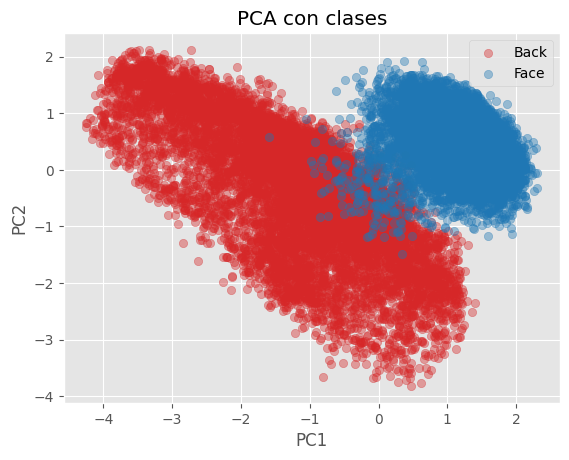

In [ ]:
# Tomar solo las primeras dos componentes para graficar
X_plot = X_pca[:, :2]


# Graficar con colores y leyenda
colors = ['tab:red', 'tab:blue']
labels = ['Back', 'Face']

for class_value in [0, 1]:
    plt.scatter(X_pca[y_train == class_value, 0], X_pca[y_train == class_value, 1], c=colors [class_value], label=labels[class_value], alpha=0.4)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA con clases')
plt.legend()
plt.grid(True)
plt.show()